# Day 3: Neural Networks (Multi Layer Perceptron)

In this example we use Multi Layer Perceptron to classify audio samples in three different classes: kick drum, snare drum, and cymbal.

### Set up the environment for this example (importing packages and configuring options)

In [1]:
#import numpy
import numpy as np

#import librosa and display the library verion installed in yoru system
import librosa, librosa.display
print(librosa.__version__)

#import matplotlib 
import matplotlib.pyplot as plt

# Render plots interactively in the notebook (not a must)
#alternatively use matplotlib inline or matplotlib notebook or matplotlib nbagg
%matplotlib inline

#select a different color-scheme for the plots
import matplotlib.style as ms
ms.use('seaborn-muted')

#importing audio widget from IPython.display for audio playback
from IPython.display import Audio

#import scipy or scientific python
import scipy

#import os (helps retrieve the file names from the directory structure on your computer, and much more)
import os

import IPython.display as ipd

#importing pandas for being able to load data from files such as comma separated values files
import pandas as pd

#import pathlib to easily write a function to work on all the files in a folder
from pathlib import Path

#importing scikit learn library for learning
import sklearn

#enable auto completion in jupiter notebook
%config IPCompleter.greedy=True

0.7.0


### Creating a dataset including features from raw data.
This is a repetition of the code in the Day 2 Jupiter Notebook. However, this time the dataset inclused also 42 cymbal samples.

In [2]:
#The next line of code includes an inline for loop 
#which will load all .wav samples starting with kick into kick_signals.
#The * star is also called wildcard, the librosa.load will be performed on all files which name starts
#with kick and ends with .wav (e.g. kick_03.wav, but also kick_adsugds.wav which we do not have in the folder).
#Mind that the sampling rate is the default one (do you remember the value?).
#The code below will actually create a LIST (squared brackets in Python) of Numpy arrays.
#Te have to take this approach because we are not sure that if files have the same number of samples (they do not)
#othrwise we could use a matrix (aka N dimensional Numpy array).
kick_signals = [ librosa.load(p, mono=True)[0] for p in Path().glob('Data/drum_samples/kick*.wav') ]

#Repeating the same for snare samples
snare_signals = [ librosa.load(p, mono=True)[0] for p in Path().glob('Data/drum_samples/snare*.wav') ]

#Repeating the same for cymbal
cymbal_signals = [ librosa.load(p, mono=True)[0] for p in Path().glob('Data/drum_samples/cymbal*.wav')]

#Printing the size (lenght, using len() ) of the lists which includes kick and snares (separately).
#Does the number make sense versus what you have in the drum_samples folder?
print(len(kick_signals))
print(len(snare_signals))
print(len(cymbal_signals))

42
42
42


In [3]:
#Instead of writing the code to extract the features we define a function,
#which is more elegant, it's reusable (shorter code) and makes the following code more readable.
#All features (5 of them) are from librosa and are all scalar (we take the mean over multiple blocks).
#We have to do this (use average) because we did not check if all files have the same lenght (actually they are different).
#Different file lenght generates Numpy arrays of different lenght (not comparable)
#The function returns a list containing the mean of the features on "signal", which is the parameter we pass to the function
#Mind that these features may not be the best to perform the classification task (it's just an example!)
def extract_features(signal):

    return [
        np.mean(librosa.feature.zero_crossing_rate(signal)),
        np.mean(librosa.feature.spectral_centroid(signal)),
        np.mean(librosa.feature.spectral_contrast(signal)),
        np.mean(librosa.feature.rms(signal)),
        np.mean(librosa.feature.spectral_flatness(signal)),
    ]


#Extracting our the 5 scalar features for all kick samples.
#Ee are using another inline for loop (this is very convenient when working with lists).
#Now we can store the data on an Numpy array because the size of the data is consistent,
#indeed we will have 5 numbers (features) per sample
#to be precise, we are still storing data into a list [], and then we use the function np.array
#to convert the list into an array (we need Numpy arrays for our ML algorithm, not lists)
kick_features = np.array([extract_features(x) for x in kick_signals])

#Repearing the same for the snare samples.
snare_features = np.array([extract_features(x) for x in snare_signals])

#repeating the same for cymbal samples
cymbal_features = np.array([extract_features(x) for x in cymbal_signals])

#Displaying the size of the Numpy arrays (this time we use the .shape attribute)
#Check if the printed numbers are the expected ones (what's on the rows and what's on the columns?)
print('Size of Numpy arrays for kick and snare features:')
print(kick_features.shape, snare_features.shape, cymbal_features.shape)

#Now we create an array of labels, we can use zeros for the kicks and ones for the snare (or any other number).
#This will help us to discriminate set of featires associated with kicks and snares
#We can opt for "text" labels but this is not convenient,
#It wont work well with neural networks, and we put "text" labels in Numpy arrays

#Create a row of zeroes as long as the number of kick samples
kicklabels = np.zeros(kick_features.shape[0])

#Create a row of ones as long as the number of snare samples
snarelabels = np.ones(snare_features.shape[0])

#Create a row of twos as long as the number of cymbal samples
cymballabels = np.full(cymbal_features.shape[0],2)

#Now we concatenate (attach) the numeric labels into a single array,
#and we also concatenate the two set of features
labels = np.concatenate((kicklabels,snarelabels,cymballabels))
features = np.concatenate((kick_features,snare_features,cymbal_features))

#check the output and reconsile these with what we just did
print('Size of labels array',labels.shape)
print('Size of feature array',features.shape)

#Here we use the scale function of scikit-learn to scale the features,
#this is important when using hetherogeneous (different) scalar features.
#After this step all features will present zero mean and unit veriance (i.e. they are more comparable).
#It is way less recommended to do this with vectorial features.
#In this case we are overwiting the previous Numpy variable (or array) instead of creating a new one
#(it is fine if you do not need the old data anymore, and it reduces the number of variables you use in a program)
features = sklearn.preprocessing.scale(features)


#Moving the data into a Pandas structure and we assign name to each column (features are on column)
dataset = pd.DataFrame(features)
dataset.columns = ['ZC','SpecCen','SpecCon','RMS','SpecFlat']

#Sticking an extra colum as labels
dataset['Label'] = labels

#creating a list of text labels, the list index (0,1,and 2) match with the numerical
#labels created above for the three classes
classes = ['kick','snare','cymbal']

#this will display the Pandas data structure
dataset


Size of Numpy arrays for kick and snare features:
(42, 5) (42, 5) (42, 5)
Size of labels array (126,)
Size of feature array (126, 5)


,ZC,SpecCen,SpecCon,RMS,SpecFlat,Label
0,-1.084031,-1.413592,-0.595389,-0.310528,1.375790,0.0
1,-0.999764,-0.960899,-0.923160,-0.326419,1.554701,0.0
2,-1.114982,-1.215975,-0.256289,-0.443750,1.078909,0.0
3,-1.095350,-1.372480,-0.896794,0.380001,1.225789,0.0
4,-1.157117,-1.540783,0.323616,3.210277,0.752310,0.0
5,-1.040870,-1.298169,-0.739203,-0.041586,1.961538,0.0
6,-1.090458,-1.148739,-0.488252,-0.351841,0.935847,0.0
7,-1.100347,-1.142564,-0.959073,-0.422594,0.901325,0.0
8,-1.189340,-1.539786,-0.533734,-0.163247,1.325410,0.0
9,-1.103735,-1.035629,-0.914679,-0.442422,0.902276,0.0


### MLP for classification
The [MLPClassifier in scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.

MLP trains on two arrays: array X of size (n_samples, n_features), which holds the training samples represented as floating point feature vectors; and array y of size (n_samples,), which holds the target values (class labels) for the training samples.

It is not necessary to explicitly specify one output neuron per class, this is already implemented in the MLPClassifier object. Moreover, the output is always one of the provided labels (whetever they are).

The MLPClassifier can learn non-linear models and can learn models in real-time (on-line learning) using partial_fit.

In [4]:
#Before proceeding with training and testing of the classifiers
#we split the data in training and testing set using a 70/30 partitioning.
#This is done a useful function in scikit-learn (called train_test_split)
#The partitioning is done randomly but starting from a seed you can specify (random_state)
#Every time you change the starting random state value, you will experience
#a different partitioning and (likely) a different classification result.

#Importing the tool,
#alternatively you can call sklearn.model_selection.train_test_split(..,..,..,)
#but that will be too long
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.3, random_state=214)

In [5]:
#Import the classifier
from sklearn.neural_network import MLPClassifier

##Creating an instance of a MLP classifier
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPClassifier(hidden_layer_sizes=(2,2), max_iter=200, verbose=True, activation='relu')

#train the model
mlp.fit(feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = mlp.predict(feat_test)

Iteration 1, loss = 1.65764518
Iteration 2, loss = 1.65352553
Iteration 3, loss = 1.64942853
Iteration 4, loss = 1.64535450
Iteration 5, loss = 1.64130376
Iteration 6, loss = 1.63727660
Iteration 7, loss = 1.63326918
Iteration 8, loss = 1.62928279
Iteration 9, loss = 1.62532053
Iteration 10, loss = 1.62138276
Iteration 11, loss = 1.61747138
Iteration 12, loss = 1.61359391
Iteration 13, loss = 1.60974103
Iteration 14, loss = 1.60591061
Iteration 15, loss = 1.60210135
Iteration 16, loss = 1.59831625
Iteration 17, loss = 1.59455464
Iteration 18, loss = 1.59081139
Iteration 19, loss = 1.58709203
Iteration 20, loss = 1.58339663
Iteration 21, loss = 1.57972522
Iteration 22, loss = 1.57607864
Iteration 23, loss = 1.57245904
Iteration 24, loss = 1.56886323
Iteration 25, loss = 1.56529110
Iteration 26, loss = 1.56174256
Iteration 27, loss = 1.55821748
Iteration 28, loss = 1.55471294
Iteration 29, loss = 1.55122827
Iteration 30, loss = 1.54776626
Iteration 31, loss = 1.54432675
Iteration 32, los

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


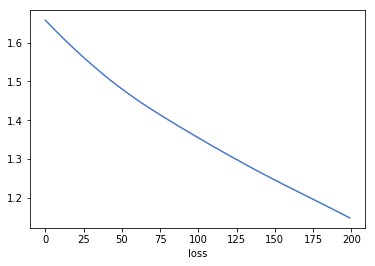

Number of mislabeled samples 25 out of 38
Accuracy: 0.34210526315789475
              precision    recall  f1-score   support

         0.0       0.35      1.00      0.52        12
         1.0       0.25      0.08      0.12        13
         2.0       0.00      0.00      0.00        13

   micro avg       0.34      0.34      0.34        38
   macro avg       0.20      0.36      0.21        38
weighted avg       0.20      0.34      0.21        38

confusion matrix
[[12  0  0]
 [12  1  0]
 [10  3  0]]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.xlabel('loss')
plt.show()

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))
print(sklearn.metrics.classification_report(lab_test, lab_predict))
print('confusion matrix')
print(sklearn.metrics.confusion_matrix(lab_test,lab_predict))

the code below is taken from [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) and it simply facilitates the visualization of the confusion matrix (ignore it and focus on the visual outcome)

Confusion matrix, without normalization
[[12  0  0]
 [12  1  0]
 [10  3  0]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.92 0.08 0.  ]
 [0.77 0.23 0.  ]]


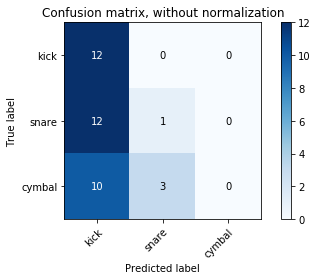

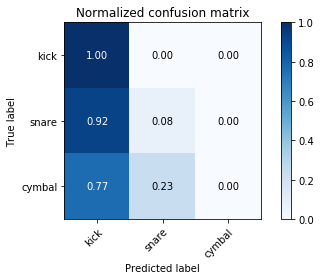

In [8]:
#fedining a function for the confusion matrix display 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[sklearn.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(lab_test, lab_predict, classes=classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(lab_test, lab_predict, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Exercise 1
a) Analyze in details the results displayed above and reconcile these with the classification task and dataset. Look at the accuracy, what gets missclassifies, inspect the trainig process (verbose mode is ON), and the displayed messages.

b) sketch (on paper) the network we are using here (and repeat this everytime you modify the network structure).

c) start to modify the network to improve the accuracy. You can explore increasing/decreasing the number of layers, the number of neuron per layer, the maximum number of training iterations, the activation function of the neurons (try logistic or tanh), and any other option you think may be relevant (refer to the documentation of MLPClassifier).

d) report the network that give you the best performance (the smaller the network the better). One strategy is to gradually grow the network rather than immediately jumping to a large one (you may think to write a loop for this for your project).

In [9]:
#write your code here

### MLP for regression
The [MLPRegressor in scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation. 

MLPRegressor also supports multi-output regression, in which a sample can have more than one target.

In the example below we use the same data we used for classification (it's not a great example but the aim here is to note the difference). You will change this in the following exercise.

In [10]:
#Import the classifier
from sklearn.neural_network import MLPRegressor

##Creating an instance of a MLP classifier
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPRegressor(hidden_layer_sizes=(2,2), max_iter=200, verbose=True, activation='relu')

#train the model
mlp.fit(feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = mlp.predict(feat_test)

Iteration 1, loss = 2.72146959
Iteration 2, loss = 2.69615949
Iteration 3, loss = 2.67105314
Iteration 4, loss = 2.64615282
Iteration 5, loss = 2.62146066
Iteration 6, loss = 2.59697871
Iteration 7, loss = 2.57270886
Iteration 8, loss = 2.54865287
Iteration 9, loss = 2.52481236
Iteration 10, loss = 2.50119874
Iteration 11, loss = 2.47783239
Iteration 12, loss = 2.45468638
Iteration 13, loss = 2.43176133
Iteration 14, loss = 2.40905559
Iteration 15, loss = 2.38657108
Iteration 16, loss = 2.36430873
Iteration 17, loss = 2.34226881
Iteration 18, loss = 2.32046570
Iteration 19, loss = 2.29888761
Iteration 20, loss = 2.27753174
Iteration 21, loss = 2.25639596
Iteration 22, loss = 2.23548184
Iteration 23, loss = 2.21478883
Iteration 24, loss = 2.19431625
Iteration 25, loss = 2.17406332
Iteration 26, loss = 2.15402919
Iteration 27, loss = 2.13421286
Iteration 28, loss = 2.11461328
Iteration 29, loss = 2.09522928
Iteration 30, loss = 2.07606687
Iteration 31, loss = 2.05712131
Iteration 32, los

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


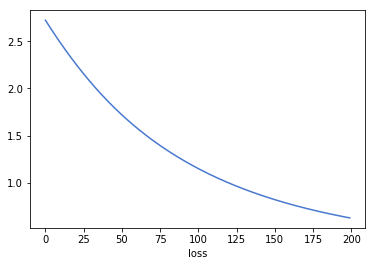

1.2365246258814175
-0.8814979555034422


In [11]:
#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.xlabel('loss')
plt.show()

#Displaying the mean squared error(MSE), and the R2 regression score (just another regression metric).
#For the mse, the lower the value the better. MSE values are difficult to compare across different data set
#R2 score is better for comparing regression performance on different dataset.
#R2 best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
#A constant model that always predicts the expected value of the output, disregarding the input features,
#would get a R^2 score of 0.0.
print(sklearn.metrics.mean_squared_error(lab_test, lab_predict))
print(sklearn.metrics.r2_score(lab_test, lab_predict, multioutput='variance_weighted') )

### Exercise 2
a) Display (print) the prediction produced as the output of the regression, and compare it with the output of the classifier. Explain the difference (if any). Focus on the numerical format rather than on the individual values.

b) Once again, modify the network to improve the performance.

c) Modify the daya to perform a more interesting prediction problem using MLPRegressor. Do not consider the labels of the samples, as we are not interested in classification anymore. Earlier we computed 5 features for each sample (the mean over the entire sample), so we have 5 values for each sample. Select three of these as the input of the network and two of these as the target output. Train the network and check the result.

For instance we can use ['SpecCen','SpecCon','SpecFlat'] as input and ['ZC','RMS'] as output. The network will try to learn to predict the zero crossing rate (ZC) and the RMS power given the three spectral features.

For a regression problem, you can have as many output as you want in the MLP (while in the MLPClassifier, everything is merged down to one output, which is sufficient to label the data).

In [12]:
#write your code here